

This lab demonstrates the fundamentals of logistic regression using PyTorch, with a focus on how poor parameter initialization can affect model training and convergence. The workflow includes data creation, model definition, visualization of the loss surface, and iterative training with detailed tracking of parameter updates.

---

## Key Steps and Concepts

### 1. **Data Generation**
- Synthetic dataset is created using PyTorch, with input values ranging from -1 to 0.9.
- Labels are assigned as 0 or 1 based on a threshold, simulating a binary classification problem.

### 2. **Model Definition**
- A custom `logistic_regression` class is implemented, inheriting from `nn.Module`.
- The model consists of a single linear layer followed by a sigmoid activation to output probabilities.

### 3. **Parameter Initialization**
- The model's weight and bias are manually set to large negative values.
- This "bad" initialization is used to illustrate its impact on the learning process and convergence.

### 4. **Loss Surface Visualization**
- The `plot_error_surfaces` class computes and visualizes the loss landscape with respect to weight and bias.
- Both 3D surface and contour plots are generated to help understand the optimization path.

### 5. **Training Loop**
- The model is trained using mini-batch gradient descent with Mean Squared Error (MSE) loss.
- Parameter updates and loss values are recorded at each step.
- Progress is visualized every 20 epochs to show how the model fit and parameter trajectory evolve.

### 6. **Evaluation**
- After training, predictions are made on the entire dataset.
- Accuracy is computed by comparing predicted labels to true labels.

---

## **Learning Outcomes**

- Understand the mechanics of logistic regression for binary classification.
- See the importance of parameter initialization and its effect on optimization.
- Gain experience with PyTorch's model, data, and training abstractions.
- Visualize the loss surface and optimization trajectory for deeper intuition.

---

## **Visuals Provided**
- Loss surface (3D and contour) for the parameter space.
- Model predictions and sigmoid curve during training.
- Parameter trajectory over the loss surface.

---

**This lab is a practical introduction to both the theory and implementation of logistic regression, with a strong emphasis on visualization and the effects of initialization.**

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


# Class for plotting error surfaces and function for plotting the results of training a model
class plot_error_surfaces(object):
    # Constructor
    def __init__(self, w_range, b_range, X, Y, n_samples=30, go=True):
        W = np.linspace(-w_range, w_range, n_samples)  # Create range for weights
        B = np.linspace(-b_range, b_range, n_samples)  # Create range for biases
        w, b = np.meshgrid(W, B)  # Create meshgrid for parameter space
        Z = np.zeros((30, 30))  # Initialize loss surface
        count1 = 0
        self.y = Y.numpy()  # Convert targets to numpy
        self.x = X.numpy()  # Convert inputs to numpy
        for w1, b1 in zip(w, b):  # Loop over meshgrid rows
            count2 = 0
            for w2, b2 in zip(w1, b1):  # Loop over meshgrid columns
                # Compute mean squared error for logistic regression output
                Z[count1, count2] = np.mean((self.y - (1 / (1 + np.exp(-1 * w2 * self.x - b2)))) ** 2)
                count2 += 1
            count1 += 1
        self.Z = Z  # Store loss surface
        self.w = w  # Store weight meshgrid
        self.b = b  # Store bias meshgrid
        self.W = []  # List to store weights during training
        self.B = []  # List to store biases during training
        self.LOSS = []  # List to store loss values during training
        self.n = 0  # Counter for iterations
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            # 3D surface plot of the loss surface
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            # Contour plot of the loss surface
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()

    # Setter to record parameters and loss at each step
    def set_para_loss(self, model, loss):
        self.n = self.n + 1  # Increment iteration counter
        self.W.append(list(model.parameters())[0].item())  # Store current weight
        self.B.append(list(model.parameters())[1].item())  # Store current bias
        self.LOSS.append(loss)  # Store current loss

    # Plot final parameter trajectory on loss surface
    def final_plot(self):
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)  # Wireframe of loss surface
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)  # Parameter trajectory
        plt.figure()
        plt.contour(self.w, self.b, self.Z)  # Contour plot
        plt.scatter(self.W, self.B, c='r', marker='x')  # Parameter trajectory
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

    # Plot predictions and parameter trajectory at current step
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label="training points")  # Plot training data
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")  # Plot estimated line
        plt.plot(self.x, 1 / (1 + np.exp(-1 * (self.W[-1] * self.x + self.B[-1]))), label='sigmoid')  # Plot sigmoid
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)  # Contour plot
        plt.scatter(self.W, self.B, c='r', marker='x')  # Parameter trajectory
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')

# Plot the diagram

def PlotStuff(X, Y, model, epoch, leg=True):
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))  # Plot model predictions
    plt.plot(X.numpy(), Y.numpy(), 'r')  # Plot true values
    if leg == True:
        plt.legend()  # Show legend if requested
    else:
        pass

In [3]:
torch.manual_seed(0)

# Creating some Random Data

In [4]:
# Create the data class

class Data(Dataset):
    # Constructor
    def __init__(self):
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)  # Create input values from -1 to 0.9, step 0.1, shape (20, 1)
        self.y = torch.zeros(self.x.shape[0], 1)       # Initialize all targets to 0, shape (20, 1)
        self.y[self.x[:, 0] > 0.2] = 1                 # Set targets to 1 where x > 0.2
        self.len = self.x.shape[0]                     # Store number of samples

    # Getter
    def __getitem__(self, index):      
        return self.x[index], self.y[index]            # Return input and target at given index

    # Get Length
    def __len__(self):
        return self.len                                # Return number of samples

# Create Data object
data_set = Data()

# Creating the Model and Total Loss Function (Cost)

The parameters:  OrderedDict([('linear.weight', tensor([[-5.]])), ('linear.bias', tensor([-10.]))])


<Figure size 640x480 with 0 Axes>

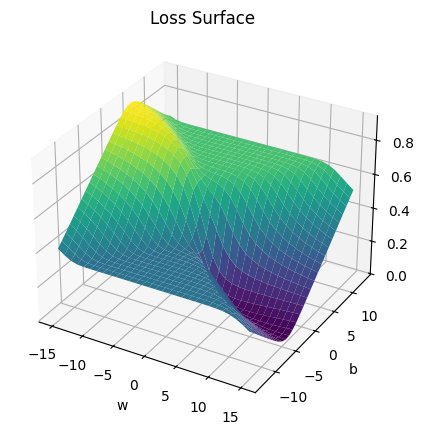

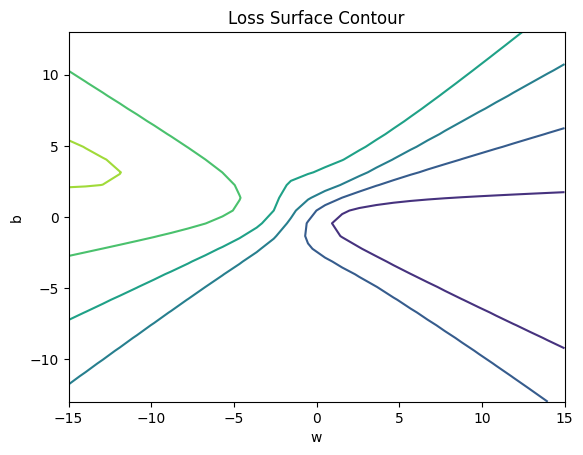

In [ ]:
# Create logistic_regression class

class logistic_regression(nn.Module):
    # Constructor: initializes the model structure
    def __init__(self, n_inputs):
        super(logistic_regression, self).__init__()      # Call parent nn.Module constructor
        self.linear = nn.Linear(n_inputs, 1)             # Define a linear layer (input_dim -> 1 output)
        
    # Forward pass: defines how input data flows through the model
    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x))             # Apply linear transformation, then sigmoid for probability
        return yhat                                      # Output is probability (between 0 and 1)

# Instantiate the logistic_regression model with 1 input feature
model = logistic_regression(1)

# Set the weight and bias to specific (bad) initial values for demonstration
model.state_dict()['linear.weight'].data[0] = torch.tensor([-5.])   # Manually set weight to -5 (steep negative slope)
model.state_dict()['linear.bias'].data[0] = torch.tensor([-10.])    # Manually set bias to -10 (large negative offset)
print("The parameters: ", model.state_dict())                       # Print model parameters to verify initialization

# Create the plot_error_surfaces object to visualize the loss surface
# This helps you see how the loss changes as weight and bias vary, and how training moves through this space
get_surface = plot_error_surfaces(
    15,                # Range for weight axis in the plot
    13,                # Range for bias axis in the plot
    data_set[:][0],    # All input features from the dataset
    data_set[:][1],    # All target labels from the dataset
    30                 # Number of samples for meshgrid (resolution of the plot)
)

# Create DataLoader for batching the data during training
trainloader = DataLoader(
    dataset=data_set,  # The dataset object
    batch_size=3       # Number of samples per batch (mini-batch gradient descent)
)

# Define the loss function (criterion) as Mean Squared Error
# Note: For logistic regression, Binary Cross Entropy is more common, but MSE is used here for illustration
criterion_rms = nn.MSELoss()

# Set the learning rate for the optimizer (step size for parameter updates)
learning_rate = 2

# Create the optimizer (Stochastic Gradient Descent) to update model parameters
optimizer = torch.optim.SGD(
    model.parameters(),  # Parameters to optimize (weight and bias)
    lr=learning_rate     # Learning rate
)

# Training the Model via Batch Gradient Descent

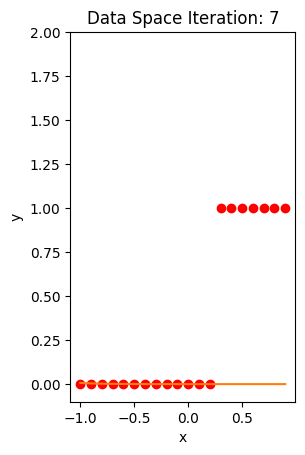

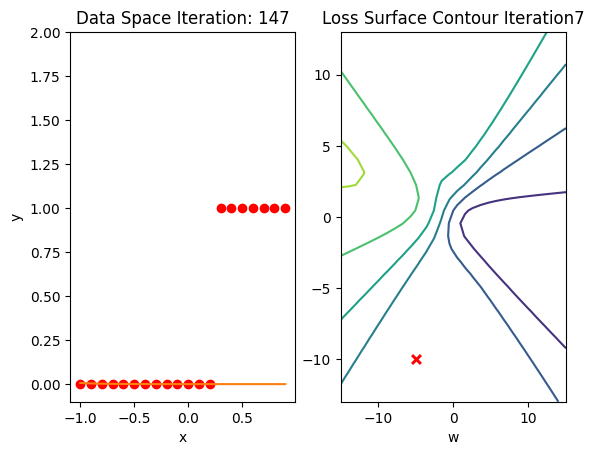

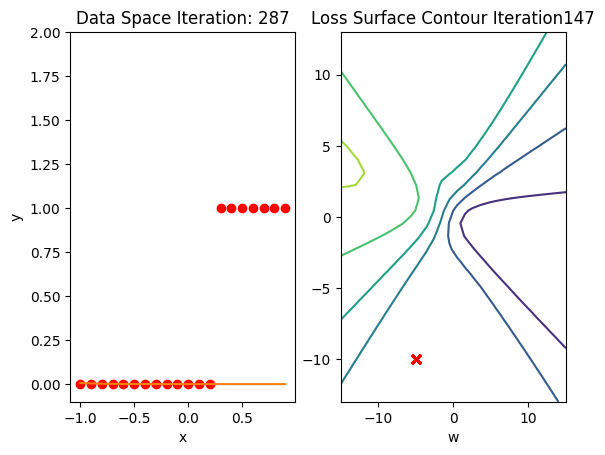

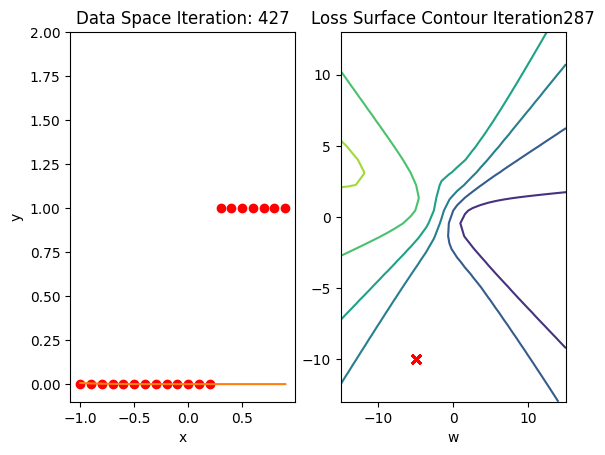

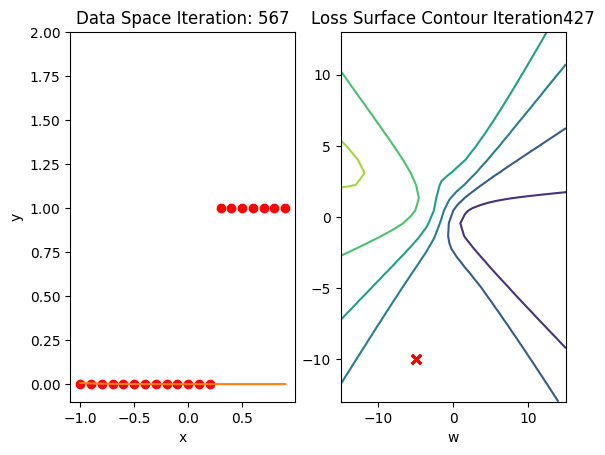

The accuracy:  tensor(0.6500)


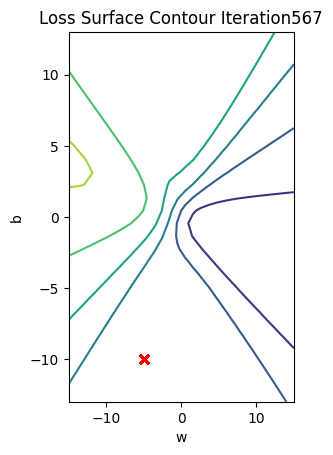

In [ ]:
# Train the model

def train_model(epochs):
    for epoch in range(epochs):  # Loop over the specified number of epochs
        for x, y in trainloader: 
            yhat = model(x)  # Forward pass: compute predicted probabilities for batch x
            loss = criterion_rms(yhat, y)  # Compute the mean squared error loss between predictions and true labels
            optimizer.zero_grad()  # Reset gradients to zero before backward pass (important in PyTorch)
            loss.backward()  # Backpropagation: compute gradients of loss w.r.t. model parameters
            optimizer.step()  # Update model parameters (weights and bias) using gradients and learning rate
            get_surface.set_para_loss(model, loss.tolist())  # Record current parameters and loss for visualization
        if epoch % 20 == 0:  # Every 20 epochs, visualize progress
            get_surface.plot_ps()  # Show current fit and parameter trajectory on loss surface

train_model(100)  # Train for 100 epochs

# Make the Prediction

yhat = model(data_set.x)  # Get predicted probabilities for all data points (forward pass)
label = yhat > 0.5  # Apply threshold: if probability > 0.5, predict class 1, else class 0
# Compare predicted labels to true labels, compute accuracy:
# - Convert true labels to ByteTensor for comparison
# - (label == data_set.y) gives a tensor of True/False (1/0)
# - Convert to float and take mean to get accuracy as a fraction
print("The accuracy: ", torch.mean((label == data_set.y.type(torch.ByteTensor)).type(torch.float)))